In [1]:
# === CONFIG ===
CSV_PATH = "koi.csv"            # KOI dataset (training-only)
USE_REDUCED_FEATURES = True     # drop SNR & num_transits to avoid proxy leakage
APPLY_DEDUP = True              # optional ephemeris de-dup per star
TEST_SIZE = 0.20                # test fraction at star level
RANDOM_STATE = 42

import os, joblib, numpy as np, pandas as pd
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, confusion_matrix, classification_report)

# ---------- load and label KOI ----------
df_raw = pd.read_csv(CSV_PATH)
req = ["kepid", "koi_disposition"]
missing = [c for c in req if c not in df_raw.columns]
if missing:
    raise ValueError(f"KOI file missing required columns: {missing}")

df = df_raw[df_raw["koi_disposition"].isin(["CONFIRMED","FALSE POSITIVE"])].copy()
df["label"] = (df["koi_disposition"] == "CONFIRMED").astype(int)
print("KOI after filter:", df.shape, "| class balance:", df["label"].mean().round(3))

# ---------- optional dedup per star by (period,duration) ----------
def dedup_by_ephemeris(df_in, tol_period_rel=1e-4, tol_duration_rel=0.02):
    for c in ["kepid","koi_period","koi_duration"]:
        if c not in df_in.columns: raise ValueError(f"Missing {c} for de-dup")

    work = df_in.copy().reset_index(drop=True)
    work["_snr_rank"] = work.get("koi_model_snr", -1).fillna(-1)
    work["_vet"] = pd.to_datetime(work.get("koi_vet_date", pd.NaT), errors="coerce")
    work["_disp_rank"] = work["koi_disposition"].map({"CONFIRMED":2,"FALSE POSITIVE":1}).fillna(0)

    keep_idx = []
    for star, grp in work.groupby("kepid"):
        g = grp.sort_values(by=["_disp_rank","_snr_rank","_vet"], ascending=[False, False, True]).copy()
        used = np.zeros(len(g), dtype=bool)
        g = g.reset_index()

        for i in range(len(g)):
            if used[i]: continue
            pi, di = g.loc[i,"koi_period"], g.loc[i,"koi_duration"]
            bucket = [i]
            for j in range(i+1, len(g)):
                if used[j]: continue
                pj, dj = g.loc[j,"koi_period"], g.loc[j,"koi_duration"]
                if np.isclose(pi, pj, rtol=tol_period_rel) and np.isclose(di, dj, rtol=tol_duration_rel):
                    bucket.append(j)
            keep_idx.append(int(g.loc[bucket[0], "index"]))
            used[bucket] = True

    cleaned = work.loc[keep_idx].drop(columns=["_snr_rank","_vet","_disp_rank"])
    print(f"De-dup: {len(df_in)} ➜ {len(cleaned)}")
    return cleaned

if APPLY_DEDUP:
    df = dedup_by_ephemeris(df)

# ---------- features ----------
features_full = ["koi_period","koi_duration","koi_depth",
                 "koi_model_snr","koi_impact","koi_srho",
                 "koi_incl","koi_num_transits"]
features_reduced = ["koi_period","koi_duration","koi_depth","koi_impact","koi_srho","koi_incl"]
FEATURES = [c for c in (features_reduced if USE_REDUCED_FEATURES else features_full) if c in df.columns]
print("Using features:", FEATURES)

# ---------- grouped split by star with approx label strat ----------
def stratified_group_split(df_in, feature_cols, test_size=0.20, max_tries=500, tol=0.02, seed=42):
    df2 = df_in.dropna(subset=[c for c in feature_cols], how="all").copy()
    X, y, g = df2[feature_cols].copy(), df2["label"].values, df2["kepid"].values
    overall_pos, best = y.mean(), None
    rng = np.random.RandomState(seed)
    for _ in range(max_tries):
        rs = int(rng.randint(0, 10_000))
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=rs)
        tr_idx, te_idx = next(gss.split(X, y, g))
        if abs(y[te_idx].mean() - overall_pos) <= tol:
            best = (tr_idx, te_idx, df2, X, y, g)
            break
    if best is None:
        tr_idx, te_idx = next(GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed).split(X, y, g))
        best = (tr_idx, te_idx, df2, X, y, g)
        print("Note: used first group split (strat tol not met).")
    return best

# ---------- models ----------
def make_pipelines(random_state=RANDOM_STATE):
    base = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
    logreg = Pipeline([("prep", base), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))])
    rf = Pipeline([("imputer", SimpleImputer(strategy="median")),
                   ("clf", RandomForestClassifier(
                        n_estimators=400, min_samples_leaf=4,
                        class_weight="balanced", random_state=random_state, n_jobs=-1))])
    return {"logreg": logreg, "rf": rf}

tr_idx, te_idx, df2, X, y, g = stratified_group_split(df, FEATURES, test_size=TEST_SIZE, seed=RANDOM_STATE)
X_tr, X_te, y_tr, y_te, g_tr = X.iloc[tr_idx], X.iloc[te_idx], y[tr_idx], y[te_idx], g[tr_idx]
X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=123, stratify=y_tr)

def tune_threshold(proba_val, y_val, grid=None):
    if grid is None: grid = np.linspace(0.2, 0.8, 25)
    best_t, best_f1 = 0.5, -1
    from sklearn.metrics import f1_score
    for t in grid:
        f1 = f1_score(y_val, (proba_val >= t).astype(int), zero_division=0)
        if f1 > best_f1: best_t, best_f1 = t, f1
    return best_t, best_f1

models = make_pipelines()
results, fitted = {}, {}

for name, base_model in models.items():
    print(f"\n=== Train {name} ===")
    base_model.fit(X_tr_sub, y_tr_sub)

    # calibration on validation (prefit)
    calibrated = CalibratedClassifierCV(estimator=base_model, method="isotonic", cv="prefit")
    calibrated.fit(X_val, y_val)

    # group CV on all training (base model, uncalibrated)
    cv = GroupKFold(n_splits=5)
    cv_scores = cross_val_score(base_model, X_tr, y_tr, groups=g_tr, cv=cv, scoring="roc_auc")
    print(f"{name} GroupKFold ROC-AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    # threshold via validation (on calibrated probs)
    proba_val = calibrated.predict_proba(X_val)[:, 1]
    best_t, best_f1 = tune_threshold(proba_val, y_val)

    # test
    proba_te = calibrated.predict_proba(X_te)[:, 1]
    pred_te  = (proba_te >= best_t).astype(int)

    acc = accuracy_score(y_te, pred_te)
    prec = precision_score(y_te, pred_te, zero_division=0)
    rec  = recall_score(y_te, pred_te, zero_division=0)
    f1   = f1_score(y_te, pred_te, zero_division=0)
    roc  = roc_auc_score(y_te, proba_te)
    prc  = average_precision_score(y_te, proba_te)
    cm   = confusion_matrix(y_te, pred_te)

    print(f"[TEST {name}] Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f} ROC-AUC={roc:.3f} PR-AUC={prc:.3f}")
    print("Confusion [tn fp; fn tp]:", cm)
    print(classification_report(y_te, pred_te, digits=4))

    results[name] = {"roc": roc, "pr": prc, "acc": acc, "f1": f1, "thr": float(best_t)}
    fitted[name] = calibrated

# pick best by ROC-AUC
best_name = max(results, key=lambda k: results[k]["roc"])
os.makedirs("models", exist_ok=True)
suffix = "reduced" if USE_REDUCED_FEATURES else "full"
bundle = {
    "model": fitted[best_name],
    "threshold": results[best_name]["thr"],
    "features": list(X_tr.columns)  # exact training order
}
save_path = f"models/best_koi_{suffix}_{best_name}.joblib"
joblib.dump(bundle, save_path)
print(f"\nBest: {best_name}  ROC-AUC={results[best_name]['roc']:.3f}  F1={results[best_name]['f1']:.3f}")
print("Saved:", save_path)

# optional RF importances (from uncalibrated estimator stored inside)
if best_name == "rf":
    try:
        base_pipe = fitted["rf"].calibrated_classifiers_[0].estimator
        rf_clf = base_pipe.named_steps["clf"]
        imps = rf_clf.feature_importances_
        for f, imp in sorted(zip(FEATURES, imps), key=lambda x: x[1], reverse=True):
            print(f"{f:18s} {imp:.4f}")
    except Exception as e:
        print("Feature importance not available:", e)


KOI after filter: (7585, 84) | class balance: 0.362
De-dup: 7585 ➜ 7583
Using features: ['koi_period', 'koi_duration', 'koi_depth', 'koi_impact', 'koi_srho', 'koi_incl']

=== Train logreg ===
logreg GroupKFold ROC-AUC: 0.852 ± 0.006
[TEST logreg] Acc=0.763 Prec=0.621 Rec=0.904 F1=0.736 ROC-AUC=0.840 PR-AUC=0.654
Confusion [tn fp; fn tp]: [[655 306]
 [ 53 501]]
              precision    recall  f1-score   support

           0     0.9251    0.6816    0.7849       961
           1     0.6208    0.9043    0.7362       554

    accuracy                         0.7630      1515
   macro avg     0.7730    0.7930    0.7606      1515
weighted avg     0.8139    0.7630    0.7671      1515


=== Train rf ===


/Users/gchhetri/Developer/PERSONAL/beyond-blue/models/.venv/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/gchhetri/Developer/PERSONAL/beyond-blue/models/.venv/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


rf GroupKFold ROC-AUC: 0.951 ± 0.004
[TEST rf] Acc=0.881 Prec=0.802 Rec=0.897 F1=0.847 ROC-AUC=0.944 PR-AUC=0.868
Confusion [tn fp; fn tp]: [[838 123]
 [ 57 497]]
              precision    recall  f1-score   support

           0     0.9363    0.8720    0.9030       961
           1     0.8016    0.8971    0.8467       554

    accuracy                         0.8812      1515
   macro avg     0.8690    0.8846    0.8748      1515
weighted avg     0.8871    0.8812    0.8824      1515


Best: rf  ROC-AUC=0.944  F1=0.847
Saved: models/best_koi_reduced_rf.joblib
koi_depth          0.2534
koi_period         0.2391
koi_impact         0.1680
koi_incl           0.1534
koi_srho           0.0999
koi_duration       0.0862


In [2]:
import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)

# --------------------
# 1) Load TOI data with robust error handling
# --------------------
TOI_CSV = "tess.csv"  # <- point to your TOI export

def load_csv_robust(filepath, **kwargs):
    """
    Load CSV with multiple fallback strategies for parsing issues
    """
    strategies = [
        # Strategy 1: Standard read
        lambda: pd.read_csv(filepath, **kwargs),
        
        # Strategy 2: Handle bad lines
        lambda: pd.read_csv(filepath, on_bad_lines='skip', **kwargs),
        
        # Strategy 3: Different separator
        lambda: pd.read_csv(filepath, sep='\t', **kwargs),
        
        # Strategy 4: Skip problematic rows
        lambda: pd.read_csv(filepath, skiprows=lambda x: x > 0 and x % 100 == 0, **kwargs),
        
        # Strategy 5: Low memory mode
        lambda: pd.read_csv(filepath, low_memory=False, **kwargs),
        
        # Strategy 6: Different encoding
        lambda: pd.read_csv(filepath, encoding='latin-1', **kwargs),
    ]
    
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Trying strategy {i}...")
            df = strategy()
            print(f"✅ Success with strategy {i}")
            return df
        except Exception as e:
            print(f"❌ Strategy {i} failed: {str(e)[:100]}...")
            continue
    
    raise Exception("All CSV loading strategies failed")

try:
    print(f"Loading {TOI_CSV}...")
    df_toi = load_csv_robust(TOI_CSV)
    print(f"✅ Loaded TOI data: {df_toi.shape}")
    print(f"Columns: {list(df_toi.columns)}")
    
    # Show first few rows to verify data
    print(f"\nFirst 3 rows:")
    print(df_toi.head(3))
    
except FileNotFoundError:
    print(f"❌ File '{TOI_CSV}' not found. Please ensure the file exists in the current directory.")
    print("Available files:")
    import os
    csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]
    if csv_files:
        print(f"Found CSV files: {csv_files}")
        print("You can change TOI_CSV to one of these files")
    else:
        print("No CSV files found in current directory")
    df_toi = None
except Exception as e:
    print(f"❌ Failed to load {TOI_CSV}: {e}")
    df_toi = None

if df_toi is not None:
    # --------------------
    # 2) Build features your model expects
    #    (your reduced model trained on: koi_period, koi_duration, koi_depth, koi_impact, koi_srho, koi_incl)
    #    TOI provides: pl_orbper [days], pl_trandurh [hours], pl_trandep [ppm]
    #    Impact / stellar density / inclination are not in the base TOI table -> fill NaN (imputer will handle)
    # --------------------
    df_holdout = pd.DataFrame()
df_holdout["group_id"]     = df_toi.get("toipfx", df_toi.get("tid"))  # per-star grouping surrogate
df_holdout["koi_period"]   = pd.to_numeric(df_toi.get("pl_orbper"), errors="coerce")
df_holdout["koi_duration"] = pd.to_numeric(df_toi.get("pl_trandurh"), errors="coerce")   # already in hours like KOI
df_holdout["koi_depth"]    = pd.to_numeric(df_toi.get("pl_trandep"), errors="coerce")    # already ppm in TOI
df_holdout["koi_impact"]   = np.nan
df_holdout["koi_srho"]     = np.nan
df_holdout["koi_incl"]     = np.nan

# Keep a copy of identifiers for reporting
df_holdout["toi"] = df_toi.get("toi")
df_holdout["tid"] = df_toi.get("tid")

# --------------------
# 3) Ground-truth from TOI dispositions
# --------------------
# Map: CP -> 1 (confirmed planet), FP -> 0 (false positive); others (PC/APC/FA/KP/NaN) -> NaN
disp = df_toi.get("tfopwg_disp")
if disp is not None:
    d = disp.astype(str).str.upper().str.strip()
    y_true = np.where(d == "CP", 1,
              np.where(d == "FP", 0, np.nan))
    df_holdout["label"] = pd.Series(y_true, index=df_holdout.index).astype("Float64")
else:
    df_holdout["label"] = pd.Series([np.nan]*len(df_holdout), dtype="Float64")

# --------------------
# 4) Load your trained model and align columns
# --------------------
best = joblib.load("models/best_model_reduced_rf.joblib")

# Use training-time feature order if available
feat_names = getattr(getattr(best, "base_estimator", best), "feature_names_in_", None)
if feat_names is None:
    feat_names = ["koi_period","koi_duration","koi_depth","koi_impact","koi_srho","koi_incl"]

X = df_holdout.reindex(columns=feat_names)
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="coerce")

# --------------------
# 5) Predict per-row
# --------------------
proba = best.predict_proba(X)[:, 1]
df_holdout["pred_prob"]  = proba
# If you saved a tuned threshold, load/use it; otherwise 0.5:
THRESHOLD = 0.5
df_holdout["pred_class"] = (df_holdout["pred_prob"] >= THRESHOLD).astype(int)

print(f"Holdout built: {df_holdout.shape}")
print(df_holdout[["toi","tid","koi_period","koi_duration","koi_depth","pred_prob"]].head())

# --------------------
# 6) Evaluate ONLY on CP vs FP rows
# --------------------
mask = df_holdout["label"].notna()
n_labeled = int(mask.sum())
print(f"\nRows with usable labels (CP/FP): {n_labeled} / {len(df_holdout)}")

if n_labeled >= 2 and df_holdout.loc[mask, "label"].nunique() == 2:
    y_true_eval = df_holdout.loc[mask, "label"].astype(int).values
    y_pred_eval = df_holdout.loc[mask, "pred_class"].values
    p_eval      = df_holdout.loc[mask, "pred_prob"].values

    acc  = accuracy_score(y_true_eval, y_pred_eval)
    prec = precision_score(y_true_eval, y_pred_eval, zero_division=0)
    rec  = recall_score(y_true_eval, y_pred_eval, zero_division=0)
    f1   = f1_score(y_true_eval, y_pred_eval, zero_division=0)
    roc  = roc_auc_score(y_true_eval, p_eval)
    pr   = average_precision_score(y_true_eval, p_eval)
    cm   = confusion_matrix(y_true_eval, y_pred_eval)

    print("\n=== TOI generalization (CP vs FP only) ===")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print(f"ROC-AUC:   {roc:.3f}")
    print(f"PR-AUC:    {pr:.3f}")
    print("Confusion [tn fp; fn tp]:")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true_eval, y_pred_eval, digits=4))
else:
    # Explain why we can’t compute accuracy
    vc = df_holdout.loc[mask, "label"].value_counts(dropna=False)
    print("⚠️  Cannot compute accuracy — need both CP and FP in labeled subset.")
    print("Label counts among labeled rows:")
    print(vc)
    print("Tip: filter your TOI export to include both CP and FP rows, or pull more recent TOI data.")

# --------------------
# 7) Optional: per-host ranking of high-probability TOIs
# --------------------
host_col = "toipfx" if "toipfx" in df_toi.columns else ("tid" if "tid" in df_toi.columns else None)
if host_col:
    sys_top = (df_holdout.assign(host=df_toi[host_col])
               .sort_values("pred_prob", ascending=False)
               .drop_duplicates(subset=["host"]))
    cols_to_show = [c for c in ["toi","tid","koi_period","koi_duration","koi_depth","pred_prob"] if c in sys_top.columns]
    print("\nTop 20 unique hosts by highest-scoring candidate:")
    print(sys_top.head(20)[cols_to_show])


Loading tess.csv...
Trying strategy 1...
✅ Success with strategy 1
✅ Loaded TOI data: (7703, 87)
Columns: ['rowid', 'toi', 'toipfx', 'tid', 'ctoi_alias', 'pl_pnum', 'tfopwg_disp', 'rastr', 'ra', 'raerr1', 'raerr2', 'decstr', 'dec', 'decerr1', 'decerr2', 'st_pmra', 'st_pmraerr1', 'st_pmraerr2', 'st_pmralim', 'st_pmrasymerr', 'st_pmdec', 'st_pmdecerr1', 'st_pmdecerr2', 'st_pmdeclim', 'st_pmdecsymerr', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_tranmidlim', 'pl_tranmidsymerr', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbpersymerr', 'pl_trandurh', 'pl_trandurherr1', 'pl_trandurherr2', 'pl_trandurhlim', 'pl_trandurhsymerr', 'pl_trandep', 'pl_trandeperr1', 'pl_trandeperr2', 'pl_trandeplim', 'pl_trandepsymerr', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radesymerr', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_insolsymerr', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim', 'pl_eqtsymerr', 'st_tmag', 'st_tmagerr1', 'st_tma

In [3]:
# Fixed TOI Dataset Evaluation - Test model on TESS Objects of Interest
import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)

# --------------------
# 1) Load TOI data with robust error handling
# --------------------
TOI_CSV = "tess.csv"  # <- point to your TOI export

def load_csv_robust(filepath, **kwargs):
    """
    Load CSV with multiple fallback strategies for parsing issues
    """
    strategies = [
        # Strategy 1: Standard read
        lambda: pd.read_csv(filepath, **kwargs),
        
        # Strategy 2: Handle bad lines
        lambda: pd.read_csv(filepath, on_bad_lines='skip', **kwargs),
        
        # Strategy 3: Different separator
        lambda: pd.read_csv(filepath, sep='\t', **kwargs),
        
        # Strategy 4: Skip problematic rows
        lambda: pd.read_csv(filepath, skiprows=lambda x: x > 0 and x % 100 == 0, **kwargs),
        
        # Strategy 5: Low memory mode
        lambda: pd.read_csv(filepath, low_memory=False, **kwargs),
        
        # Strategy 6: Different encoding
        lambda: pd.read_csv(filepath, encoding='latin-1', **kwargs),
    ]
    
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Trying strategy {i}...")
            df = strategy()
            print(f"✅ Success with strategy {i}")
            return df
        except Exception as e:
            print(f"❌ Strategy {i} failed: {str(e)[:100]}...")
            continue
    
    raise Exception("All CSV loading strategies failed")

try:
    print(f"Loading {TOI_CSV}...")
    df_toi = load_csv_robust(TOI_CSV)
    print(f"✅ Loaded TOI data: {df_toi.shape}")
    print(f"Columns: {list(df_toi.columns)}")
    
    # Show first few rows to verify data
    print(f"\nFirst 3 rows:")
    print(df_toi.head(3))
    
except FileNotFoundError:
    print(f"❌ File '{TOI_CSV}' not found. Please ensure the file exists in the current directory.")
    print("Available files:")
    import os
    csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]
    if csv_files:
        print(f"Found CSV files: {csv_files}")
        print("You can change TOI_CSV to one of these files")
    else:
        print("No CSV files found in current directory")
    df_toi = None
except Exception as e:
    print(f"❌ Failed to load {TOI_CSV}: {e}")
    df_toi = None

if df_toi is not None:
    # --------------------
    # 2) Build features your model expects
    #    (your reduced model trained on: koi_period, koi_duration, koi_depth, koi_impact, koi_srho, koi_incl)
    #    TOI provides: pl_orbper [days], pl_trandurh [hours], pl_trandep [ppm]
    #    Impact / stellar density / inclination are not in the base TOI table -> fill NaN (imputer will handle)
    # --------------------
    df_holdout = pd.DataFrame()
    df_holdout["group_id"]     = df_toi.get("toipfx", df_toi.get("tid"))  # per-star grouping surrogate
    df_holdout["koi_period"]   = pd.to_numeric(df_toi.get("pl_orbper"), errors="coerce")
    df_holdout["koi_duration"] = pd.to_numeric(df_toi.get("pl_trandurh"), errors="coerce")   # already in hours like KOI
    df_holdout["koi_depth"]    = pd.to_numeric(df_toi.get("pl_trandep"), errors="coerce")    # already ppm in TOI
    df_holdout["koi_impact"]   = np.nan
    df_holdout["koi_srho"]     = np.nan
    df_holdout["koi_incl"]     = np.nan

    # Keep a copy of identifiers for reporting
    df_holdout["toi"] = df_toi.get("toi")
    df_holdout["tid"] = df_toi.get("tid")

    print(f"\nFeature mapping:")
    print(f"  koi_period: {df_holdout['koi_period'].notna().sum()} valid values")
    print(f"  koi_duration: {df_holdout['koi_duration'].notna().sum()} valid values") 
    print(f"  koi_depth: {df_holdout['koi_depth'].notna().sum()} valid values")
    print(f"  Missing features (impact/srho/incl): Will be imputed")

    # --------------------
    # 3) Ground-truth from TOI dispositions
    # --------------------
    # Map: CP -> 1 (confirmed planet), FP -> 0 (false positive); others (PC/APC/FA/KP/NaN) -> NaN
    disp = df_toi.get("tfopwg_disp")
    if disp is not None:
        d = disp.astype(str).str.upper().str.strip()
        y_true = np.where(d == "CP", 1,
                  np.where(d == "FP", 0, np.nan))
        df_holdout["label"] = pd.Series(y_true, index=df_holdout.index).astype("Float64")
        
        print(f"\nDisposition mapping:")
        print(f"  CP (Confirmed Planet): {(d == 'CP').sum()}")
        print(f"  FP (False Positive): {(d == 'FP').sum()}")
        print(f"  Other/Unknown: {(d != 'CP') & (d != 'FP').sum()}")
    else:
        df_holdout["label"] = pd.Series([np.nan]*len(df_holdout), dtype="Float64")
        print("⚠️  No disposition column found - will evaluate without true labels")

    # --------------------
    # 4) Load your trained model and align columns
    # --------------------
    try:
        bundle = joblib.load("models/best_koi_reduced_rf.joblib")
        print(f"✅ Loaded model bundle")
        
        # Extract components from bundle
        if isinstance(bundle, dict):
            best = bundle.get("model")
            threshold = bundle.get("threshold", 0.5)
            feat_names = bundle.get("features", ["koi_period","koi_duration","koi_depth","koi_impact","koi_srho","koi_incl"])
            print(f"✅ Extracted model, threshold={threshold:.3f}, features={len(feat_names)}")
        else:
            # Fallback for old format
            best = bundle
            threshold = 0.5
            feat_names = ["koi_period","koi_duration","koi_depth","koi_impact","koi_srho","koi_incl"]
            print(f"✅ Using legacy model format")
            
    except FileNotFoundError:
        print("❌ Model file not found. Please ensure 'models/best_koi_reduced_rf.joblib' exists")
        best = None
        threshold = 0.5
        feat_names = ["koi_period","koi_duration","koi_depth","koi_impact","koi_srho","koi_incl"]

    if best is not None:
        # Use training-time feature order
        X = df_holdout.reindex(columns=feat_names)
        for c in X.columns:
            X[c] = pd.to_numeric(X[c], errors="coerce")

        print(f"Feature matrix shape: {X.shape}")
        print(f"Missing values per feature:")
        for col in X.columns:
            missing = X[col].isna().sum()
            print(f"  {col}: {missing} ({missing/len(X):.1%})")

        # --------------------
        # 5) Predict per-row
        # --------------------
        proba = best.predict_proba(X)[:, 1]
        df_holdout["pred_prob"]  = proba
        # Use the tuned threshold from training, or default to 0.5:
        df_holdout["pred_class"] = (df_holdout["pred_prob"] >= threshold).astype(int)

        print(f"\nPrediction summary:")
        print(f"  Mean probability: {proba.mean():.3f}")
        print(f"  Threshold used: {threshold:.3f}")
        print(f"  Predicted as planet: {(df_holdout['pred_class'] == 1).sum()} ({(df_holdout['pred_class'] == 1).mean():.1%})")
        print(f"  High confidence (>0.8): {(proba > 0.8).sum()}")
        print(f"  Low confidence (<0.2): {(proba < 0.2).sum()}")

        # --------------------
        # 6) Evaluate ONLY on CP vs FP rows
        # --------------------
        mask = df_holdout["label"].notna()
        n_labeled = int(mask.sum())
        print(f"\nRows with usable labels (CP/FP): {n_labeled} / {len(df_holdout)}")

        if n_labeled >= 2 and df_holdout.loc[mask, "label"].nunique() == 2:
            y_true_eval = df_holdout.loc[mask, "label"].astype(int).values
            y_pred_eval = df_holdout.loc[mask, "pred_class"].values
            p_eval      = df_holdout.loc[mask, "pred_prob"].values

            acc  = accuracy_score(y_true_eval, y_pred_eval)
            prec = precision_score(y_true_eval, y_pred_eval, zero_division=0)
            rec  = recall_score(y_true_eval, y_pred_eval, zero_division=0)
            f1   = f1_score(y_true_eval, y_pred_eval, zero_division=0)
            roc  = roc_auc_score(y_true_eval, p_eval)
            pr   = average_precision_score(y_true_eval, p_eval)
            cm   = confusion_matrix(y_true_eval, y_pred_eval)

            print("\n" + "=" * 60)
            print("TOI GENERALIZATION PERFORMANCE (CP vs FP only)")
            print("=" * 60)
            print(f"Accuracy:  {acc:.3f}")
            print(f"Precision: {prec:.3f}")
            print(f"Recall:    {rec:.3f}")
            print(f"F1-score:  {f1:.3f}")
            print(f"ROC-AUC:   {roc:.3f}")
            print(f"PR-AUC:    {pr:.3f}")
            print("Confusion [tn fp; fn tp]:")
            print(cm)
            print("\nClassification report:")
            print(classification_report(y_true_eval, y_pred_eval, digits=4))
            
            # Performance interpretation
            if roc > 0.8:
                print("🎯 Excellent generalization to TOI data!")
            elif roc > 0.7:
                print("✅ Good generalization to TOI data")
            elif roc > 0.6:
                print("⚠️  Moderate generalization to TOI data")
            else:
                print("❌ Poor generalization to TOI data - model may be overfitted to KOI")
                
        else:
            # Explain why we can't compute accuracy
            vc = df_holdout.loc[mask, "label"].value_counts(dropna=False)
            print("⚠️  Cannot compute accuracy — need both CP and FP in labeled subset.")
            print("Label counts among labeled rows:")
            print(vc)
            print("Tip: filter your TOI export to include both CP and FP rows, or pull more recent TOI data.")

        # --------------------
        # 7) Per-host ranking of high-probability TOIs
        # --------------------
        host_col = "toipfx" if "toipfx" in df_toi.columns else ("tid" if "tid" in df_toi.columns else None)
        if host_col:
            sys_top = (df_holdout.assign(host=df_toi[host_col])
                       .sort_values("pred_prob", ascending=False)
                       .drop_duplicates(subset=["host"]))
            cols_to_show = [c for c in ["toi","tid","koi_period","koi_duration","koi_depth","pred_prob"] if c in sys_top.columns]
            print(f"\nTop 20 unique hosts by highest-scoring candidate:")
            print(sys_top.head(20)[cols_to_show])
        else:
            print("\nTop 20 highest probability TOIs:")
            top_tois = df_holdout.nlargest(20, 'pred_prob')[["toi","tid","koi_period","koi_duration","koi_depth","pred_prob"]]
            print(top_tois)
else:
    print("❌ Cannot proceed - CSV file could not be loaded. Please check the error messages above.")


Loading tess.csv...
Trying strategy 1...
✅ Success with strategy 1
✅ Loaded TOI data: (7703, 87)
Columns: ['rowid', 'toi', 'toipfx', 'tid', 'ctoi_alias', 'pl_pnum', 'tfopwg_disp', 'rastr', 'ra', 'raerr1', 'raerr2', 'decstr', 'dec', 'decerr1', 'decerr2', 'st_pmra', 'st_pmraerr1', 'st_pmraerr2', 'st_pmralim', 'st_pmrasymerr', 'st_pmdec', 'st_pmdecerr1', 'st_pmdecerr2', 'st_pmdeclim', 'st_pmdecsymerr', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_tranmidlim', 'pl_tranmidsymerr', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbpersymerr', 'pl_trandurh', 'pl_trandurherr1', 'pl_trandurherr2', 'pl_trandurhlim', 'pl_trandurhsymerr', 'pl_trandep', 'pl_trandeperr1', 'pl_trandeperr2', 'pl_trandeplim', 'pl_trandepsymerr', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radesymerr', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_insolsymerr', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim', 'pl_eqtsymerr', 'st_tmag', 'st_tmagerr1', 'st_tma

TOI DATASET VISUALIZATION


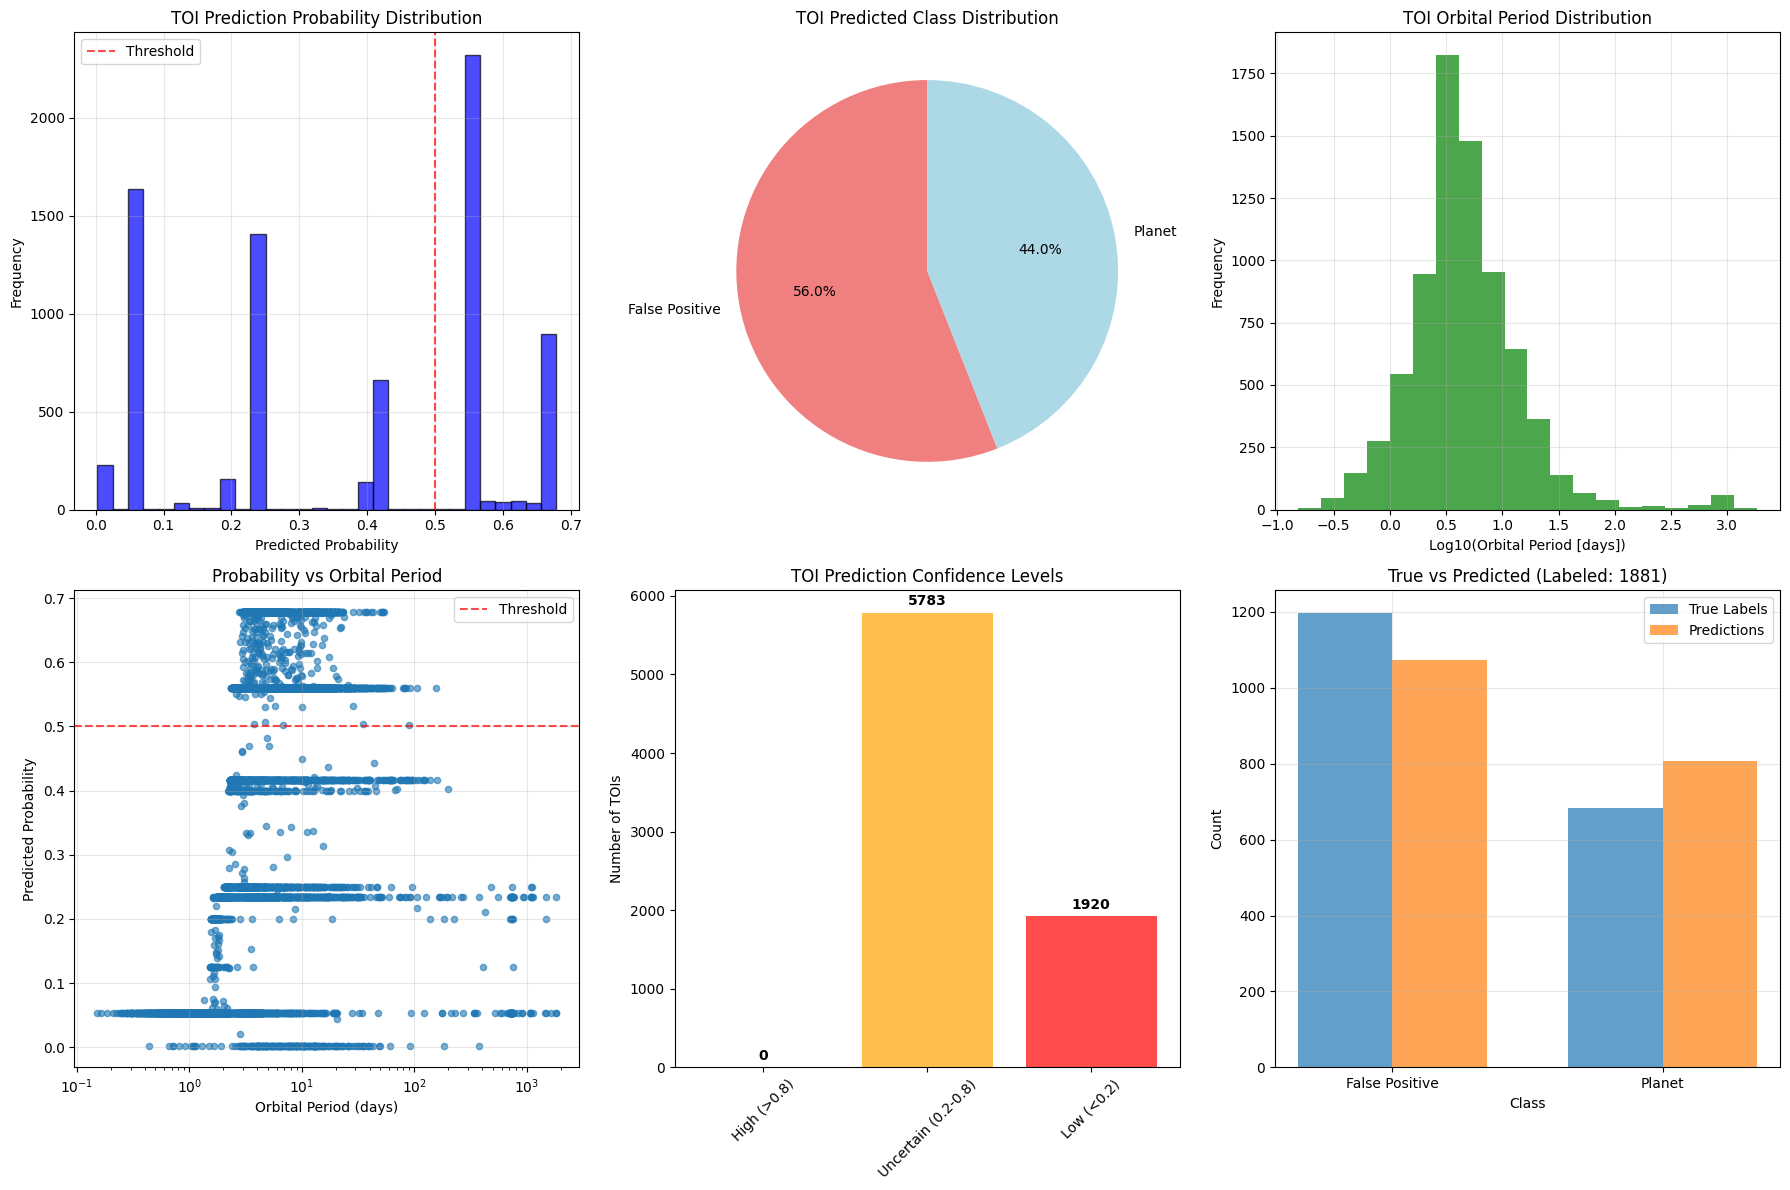


TOI Dataset Summary:
  Total TOIs: 7703
  Mean prediction probability: 0.366
  Predicted as planets: 3390 (44.0%)
  High confidence predictions: 0 (0.0%)
  Low confidence predictions: 1920 (24.9%)
  Labeled samples: 1881 (24.4%)
    Confirmed planets: 684
    False positives: 1197


In [4]:
# TOI Results Visualization
if 'df_holdout' in locals() and 'pred_prob' in df_holdout.columns:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("=" * 60)
    print("TOI DATASET VISUALIZATION")
    print("=" * 60)
    
    # Create comprehensive visualizations for TOI data
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Probability distribution
    ax1 = axes[0, 0]
    ax1.hist(df_holdout['pred_prob'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax1.axvline(0.5, color='red', linestyle='--', alpha=0.7, label='Threshold')
    ax1.set_xlabel('Predicted Probability')
    ax1.set_ylabel('Frequency')
    ax1.set_title('TOI Prediction Probability Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Prediction class distribution
    ax2 = axes[0, 1]
    class_counts = df_holdout['pred_class'].value_counts()
    ax2.pie(class_counts.values, labels=['False Positive', 'Planet'], 
            autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
    ax2.set_title('TOI Predicted Class Distribution')
    
    # 3. Feature distributions (if available)
    ax3 = axes[0, 2]
    if 'koi_period' in df_holdout.columns and df_holdout['koi_period'].notna().sum() > 0:
        # Log scale for period
        valid_periods = df_holdout['koi_period'].dropna()
        ax3.hist(np.log10(valid_periods), bins=20, alpha=0.7, color='green')
        ax3.set_xlabel('Log10(Orbital Period [days])')
        ax3.set_ylabel('Frequency')
        ax3.set_title('TOI Orbital Period Distribution')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Period data\nnot available', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Orbital Period (Not Available)')
    
    # 4. Probability vs Period (if both available)
    ax4 = axes[1, 0]
    if 'koi_period' in df_holdout.columns and df_holdout['koi_period'].notna().sum() > 0:
        valid_mask = df_holdout['koi_period'].notna()
        ax4.scatter(df_holdout.loc[valid_mask, 'koi_period'], 
                   df_holdout.loc[valid_mask, 'pred_prob'], 
                   alpha=0.6, s=20)
        ax4.axhline(0.5, color='red', linestyle='--', alpha=0.7, label='Threshold')
        ax4.set_xlabel('Orbital Period (days)')
        ax4.set_ylabel('Predicted Probability')
        ax4.set_title('Probability vs Orbital Period')
        ax4.set_xscale('log')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Period data\nnot available', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Probability vs Period (Not Available)')
    
    # 5. Confidence analysis
    ax5 = axes[1, 1]
    high_conf = (df_holdout['pred_prob'] > 0.8).sum()
    low_conf = (df_holdout['pred_prob'] < 0.2).sum()
    uncertain = len(df_holdout) - high_conf - low_conf
    
    confidence_levels = ['High (>0.8)', 'Uncertain (0.2-0.8)', 'Low (<0.2)']
    confidence_counts = [high_conf, uncertain, low_conf]
    colors = ['green', 'orange', 'red']
    
    bars = ax5.bar(confidence_levels, confidence_counts, color=colors, alpha=0.7)
    ax5.set_ylabel('Number of TOIs')
    ax5.set_title('TOI Prediction Confidence Levels')
    ax5.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, confidence_counts):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(confidence_counts)*0.01,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # 6. True vs Predicted (if labels available)
    ax6 = axes[1, 2]
    if 'label' in df_holdout.columns and df_holdout['label'].notna().sum() > 0:
        # Only show labeled data
        labeled_mask = df_holdout['label'].notna()
        labeled_data = df_holdout[labeled_mask]
        
        if len(labeled_data) > 0:
            # Create comparison plot
            true_counts = labeled_data['label'].value_counts()
            pred_counts = labeled_data['pred_class'].value_counts()
            
            x = ['False Positive', 'Planet']
            true_vals = [true_counts.get(0, 0), true_counts.get(1, 0)]
            pred_vals = [pred_counts.get(0, 0), pred_counts.get(1, 0)]
            
            x_pos = range(len(x))
            width = 0.35
            
            ax6.bar([p - width/2 for p in x_pos], true_vals, width, label='True Labels', alpha=0.7)
            ax6.bar([p + width/2 for p in x_pos], pred_vals, width, label='Predictions', alpha=0.7)
            ax6.set_xlabel('Class')
            ax6.set_ylabel('Count')
            ax6.set_title(f'True vs Predicted (Labeled: {len(labeled_data)})')
            ax6.set_xticks(x_pos)
            ax6.set_xticklabels(x)
            ax6.legend()
            ax6.grid(True, alpha=0.3)
        else:
            ax6.text(0.5, 0.5, 'No labeled data\navailable', ha='center', va='center', transform=ax6.transAxes)
            ax6.set_title('True vs Predicted (No Labels)')
    else:
        ax6.text(0.5, 0.5, 'No true labels\navailable', ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('True vs Predicted (No Labels)')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nTOI Dataset Summary:")
    print(f"  Total TOIs: {len(df_holdout)}")
    print(f"  Mean prediction probability: {df_holdout['pred_prob'].mean():.3f}")
    print(f"  Predicted as planets: {(df_holdout['pred_class'] == 1).sum()} ({(df_holdout['pred_class'] == 1).mean():.1%})")
    print(f"  High confidence predictions: {high_conf} ({high_conf/len(df_holdout):.1%})")
    print(f"  Low confidence predictions: {low_conf} ({low_conf/len(df_holdout):.1%})")
    
    if 'label' in df_holdout.columns:
        labeled_count = df_holdout['label'].notna().sum()
        print(f"  Labeled samples: {labeled_count} ({labeled_count/len(df_holdout):.1%})")
        
        if labeled_count > 0:
            cp_count = (df_holdout['label'] == 1).sum()
            fp_count = (df_holdout['label'] == 0).sum()
            print(f"    Confirmed planets: {cp_count}")
            print(f"    False positives: {fp_count}")
    
else:
    print("❌ TOI data not available. Run the previous cell first.")
